In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import random
from tqdm import tqdm
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

## Set path to project

In [6]:
if 'SIMULATED_ROOT' not in os.environ or 'SIMULATED_DATA_ROOT' not in os.environ:
    raise 'Set paths'
base_path = os.environ['SIMULATED_ROOT']
data_path = os.environ['SIMULATED_DATA_ROOT']

# 1. Naive Model

LSTM that given 180 raw input frames, predicts the next 60 output frames

## Set hyperparameters

In [7]:
class Config():
    def __init__(self):
        self.batch_size = 256
        self.loss_discount_factor = .85
        self.conv_filters = 64
        self.hidden_width = 128
        self.input_width = 180
        self.output_width = 60
        self.sampling_rate = 1
        self.stride = 6
cfg = Config()

### Create the data generator for the naive model

In [8]:
class NaiveDataGenerator():
    def __init__(self):
        self.data_cols = ['target_posX', 'target_posY', 'target_posZ', 
                          'target_rotX', 'target_rotY', 'target_rotZ', 'target_rotW', 
                          'hand_posX', 'hand_posY', 'hand_posZ']
        self.output_shapes = (
            (None, cfg.input_width, 10), 
            (None, cfg.output_width, 10)
        )
        self.output_types = (tf.float32, tf.float32)
        self.stores = {
            'train': pd.HDFStore(f'{data_path}/train.h5'),
            'dev': pd.HDFStore(f'{data_path}/dev.h5'),
            'test': pd.HDFStore(f'{data_path}/test.h5')
        }
        self.sessions = {
            'train': self.stores['train'].select_column('df', 'id').unique().tolist(),
            'dev': self.stores['dev'].select_column('df', 'id').unique().tolist(),
            'test': self.stores['test'].select_column('df', 'id').unique().tolist()
        }
        
    def generate_train(self):
        return self.generate('train')

    def generate_dev(self):
        return self.generate('dev')

    def generate_test(self):
        return self.generate('test')

    @property
    def train(self):
        return tf.data.Dataset.from_generator(
            self.generate_train, output_types=self.output_types, output_shapes=self.output_shapes)

    @property
    def dev(self):
        return tf.data.Dataset.from_generator(
            self.generate_dev, output_types=self.output_types, output_shapes=self.output_shapes)

    @property
    def test(self):
        return tf.data.Dataset.from_generator(
            self.generate_test, output_types=self.output_types, output_shapes=self.output_shapes)
        
    def generate(self, type):
        store = self.stores[type]
        sessions = self.sessions[type]
        random.shuffle(sessions)
        for session in sessions:
            df = store.select('df', 'id=%r' % session)
            assert df.index.values[0][0] == df.index.values[-1][0]
            data = df[self.data_cols].to_numpy(dtype=np.float32)
            ds = self.make_window_dataset(data)
            for x, y in ds:
                yield x, y
        
    def make_window_dataset(self, data):
        total_width = cfg.input_width + cfg.output_width
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=total_width,
            sequence_stride=cfg.stride,
            sampling_rate=cfg.sampling_rate,
            shuffle=True,
            batch_size=cfg.batch_size,
            end_index=data.shape[0] - total_width
        )
        ds = ds.map(self.split_window)
        return ds
        
    def split_window(self, window):
        x = window[:, :cfg.input_width, :]
        y = window[:, cfg.input_width:, :]
        x.set_shape([None, cfg.input_width, 10])
        y.set_shape([None, cfg.output_width, 10])
        return x, y    
        
data_generator = NaiveDataGenerator()

### Verify that the generator is working
Visualize a train sample

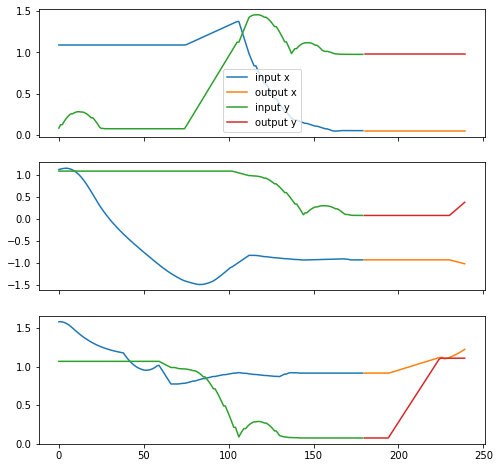

In [9]:
import matplotlib.pyplot as plt
iterator = iter(data_generator.train)
fig, ax = plt.subplots(3, 1, figsize=(8, 8), sharex=True)
for i in range(3):
    x, y = next(iterator)
    input_target_pos_x = x[0,:,0]
    input_target_pos_y = x[0,:,1]
    output_target_pos_x = y[0,:,0]
    output_target_pos_y = y[0,:,1]
    input_range = np.arange(0, cfg.input_width)
    output_range = np.arange(cfg.input_width, cfg.input_width + cfg.output_width)
    ax[i].plot(input_range, input_target_pos_x, label='input x')
    ax[i].plot(output_range, output_target_pos_x, label='output x')
    ax[i].plot(input_range, input_target_pos_y, label='input y')
    ax[i].plot(output_range, output_target_pos_y, label='output y')
    if i == 0:
        ax[i].legend()
plt.show()

### Code for the naive model

In [10]:
class NaiveModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense = tf.keras.layers.Dense(cfg.hidden_width)
        self.lstm_cell = tf.keras.layers.LSTMCell(cfg.hidden_width)
        self.lstm = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.output_layer = tf.keras.layers.Dense(10)
        
    def warmup(self, x):
        x = self.dense(x)
        x, *state = self.lstm(x)
        return x, state
    
    def call(self, x, training=None):
        predictions = []
        x, state = self.warmup(x)        
        first_prediction = self.output_layer(x)
        predictions.append(first_prediction)
        for _ in range(1, cfg.output_width):
            x, state = self.lstm_cell(x, states=state, training=training)
            next_prediction = self.output_layer(x)
            predictions.append(next_prediction)            
        predictions = tf.transpose(tf.stack(predictions), [1, 0, 2])
        return predictions        

### Train the naive model

<b>Discounted loss function</b>

In [11]:
def discounted_mse(y_true, y_pred):
    discount = np.power(np.ones(y_true.shape[1]) * cfg.loss_discount_factor, np.arange(y_true.shape[1])).reshape((1, -1))
    discount = tf.convert_to_tensor(discount, dtype=tf.float32)
    loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    return loss * discount

<b>Training loop</b> 

In [12]:
weights_path = f'{base_path}/outputs/batch256/weights.h5' #SET WEIGHTS PATH

In [13]:
model = NaiveModel()
model(next(iter(data_generator.train))[0])
model.load_weights(weights_path)
print(f'Loaded weights from path: {weights_path}')

OSError: Unable to open file (unable to open file: name = 'C:\Users\dylan\Documents\Simulated/outputs/batch256/weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### Visualize model predictions
See how predicted trajectory compares to true trajectory on test data

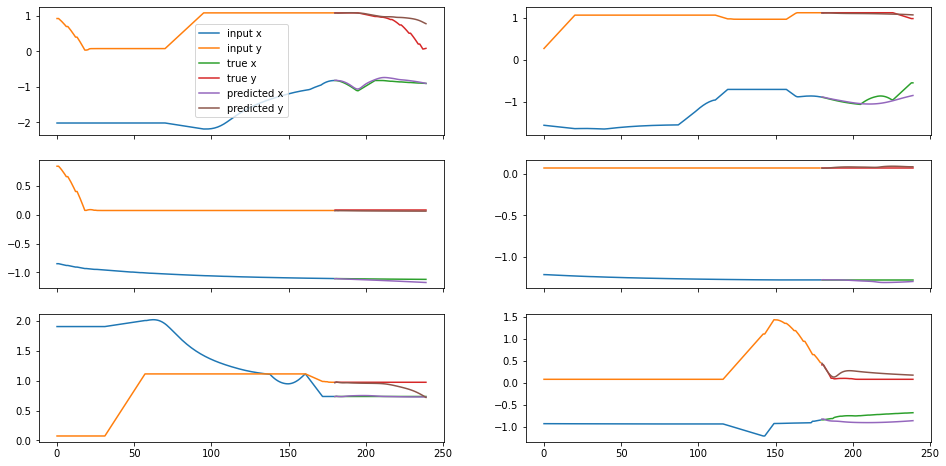

In [12]:
import matplotlib.pyplot as plt
iterator = iter(data_generator.test)
fig, ax = plt.subplots(3, 2, figsize=(16, 8), sharex=True)
for i in range(6):
    x, y = next(iterator)
    y_pred = model(x)
    input_target_pos_x = x[0,:,0]
    input_target_pos_y = x[0,:,1]
    output_target_pos_x = y[0,:,0]
    output_target_pos_y = y[0,:,1]
    pred_target_x = y_pred[0,:,0]
    pred_target_y = y_pred[0,:,1]
    input_range = np.arange(0, cfg.input_width)
    output_range = np.arange(cfg.input_width, cfg.input_width + cfg.output_width)
    ax[i % 3, i // 3].plot(input_range, input_target_pos_x, label='input x')
    ax[i % 3, i // 3].plot(input_range, input_target_pos_y, label='input y')
    ax[i % 3, i // 3].plot(output_range, output_target_pos_x, label='true x')
    ax[i % 3, i // 3].plot(output_range, output_target_pos_y, label='true y')
    ax[i % 3, i // 3].plot(output_range, pred_target_x, label='predicted x')
    ax[i % 3, i // 3].plot(output_range, pred_target_y, label='predicted y')
    if i == 0:
        ax[0, 0].legend()
plt.show()

### Evaluate model on linear probe

<b>Data generator for linear probe</b>

In [13]:
class ProbeDataGenerator():
    def __init__(self):
        self.data_cols = ['target_posX', 'target_posY', 'target_posZ', 
                          'target_rotX', 'target_rotY', 'target_rotZ', 'target_rotW', 
                          'hand_posX', 'hand_posY', 'hand_posZ', 'hand_state']
        self.output_shapes = (
            (None, cfg.input_width, 10),
            (None, cfg.input_width)
        )
        self.output_types = (tf.float32, tf.int64)
        self.stores = {
            'train': pd.HDFStore(f'{base_path}/data/train.h5'),
            'dev': pd.HDFStore(f'{base_path}/data/dev.h5'),
            'test': pd.HDFStore(f'{base_path}/data/test.h5')
        }
        self.sessions = {
            'train': self.stores['train'].select_column('df', 'id').unique().tolist(),
            'dev': self.stores['dev'].select_column('df', 'id').unique().tolist(),
            'test': self.stores['test'].select_column('df', 'id').unique().tolist()
        }
        
    def generate_train(self):
        return self.generate('train')

    def generate_dev(self):
        return self.generate('dev')

    def generate_test(self):
        return self.generate('test')

    @property
    def train(self):
        return tf.data.Dataset.from_generator(self.generate_train, output_types=self.output_types, output_shapes=self.output_shapes)

    @property
    def dev(self):
        return tf.data.Dataset.from_generator(self.generate_dev, output_types=self.output_types, output_shapes=self.output_shapes)

    @property
    def test(self):
        return tf.data.Dataset.from_generator(self.generate_test, output_types=self.output_types, output_shapes=self.output_shapes)
    
    def generate(self, type):
        store = self.stores[type]
        sessions = self.sessions[type]
        random.shuffle(sessions)
        for session in sessions:
            df = store.select('df', 'id=%r' % session)
            assert df.index.values[0][0] == df.index.values[-1][0]
            data = df[self.data_cols].to_numpy(dtype=np.float32)
            ds = self.make_window_dataset(data)
            for x, y in ds:
                yield x, y
        
    def make_window_dataset(self, data):
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=cfg.input_width,
            sequence_stride=cfg.input_width,
            sampling_rate=cfg.sampling_rate,
            shuffle=True,
            batch_size=cfg.batch_size,
            end_index=data.shape[0] - cfg.input_width
        )
        ds = ds.map(self.split_window)
        return ds
        
    def split_window(self, window):
        states = window[:, :, -1]
        window = window[:, :, :-1]
        states.set_shape([None, cfg.input_width])
        window.set_shape([None, cfg.input_width, 10])
        return window, states
    
probe_generator = ProbeDataGenerator()

<b>Build the probe</b>

In [14]:
class LinearProbe(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.rnn = tf.keras.layers.RNN(self.model.lstm_cell, return_sequences=True)
        self.output_layer = tf.keras.layers.Dense(10, activation='softmax')
        self.model.trainable = False
        self.rnn.trainable = False
        
    def call(self, x):
        x = self.model.dense(x)
        x = self.rnn(x)
        return self.output_layer(x)

<b>Train the model</b>

In [15]:
probe_weights_path = f'{base_path}/outputs/batch256/probe_weights.h5' #SET PROBE WEIGHTS PATH

In [ ]:
probe_model = LinearProbe(model)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    probe_weights_path, verbose=1, save_best_only=True, save_weights_only=True)
callbacks = [early_stopping, checkpoint]
probe_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
probe_model(next(iter(probe_generator.train))[0])
probe_model.summary()
probe_model.fit(probe_generator.train, validation_data=probe_generator.dev, callbacks=callbacks, epochs=999, verbose=1)

Alternatively, load weights from file

In [16]:
probe_model = LinearProbe(model)
probe_model(next(iter(probe_generator.train))[0])
probe_model.load_weights(probe_weights_path)
print(f'Loaded weights from path: {probe_weights_path}')

Loaded weights from path: C:\Users\dylan\Documents\Simulated/outputs/batch256/probe_weights.h5


<b>Evaluate the probe</b>

In [17]:
y_true = []
y_pred = []
for x, y in tqdm(probe_generator.dev):
    y_ = probe_model(x)
    y_ = tf.math.argmax(y_, axis=-1)
    y = tf.reshape(y, (-1,))
    y_ = tf.reshape(y_, (-1,))
    y_true.append(y)
    y_pred.append(y_)
y_true = tf.concat(y_true, axis=0)
y_pred = tf.concat(y_pred, axis=0)

100it [00:28,  3.48it/s]


In [18]:
acc = accuracy_score(y_true, y_pred)
scores = precision_recall_fscore_support(y_true, y_pred, average='macro')
print(f'Accuracy: {acc:.2f}\nPrecision: {scores[0]:.2f}\nRecall: {scores[1]:.2f}\nF-score: {scores[2]:.2f}')

Accuracy: 0.96
Precision: 0.88
Recall: 0.82
F-score: 0.85


# Chunked Model

Similar to before, but input is divided into chunks that are encoded piece-by-piece by a convolutional encoder

<img src="../docs/Chunked.png">

### Set hyperparameters

In [46]:
class Config():
    def __init__(self):
        self.batch_size = 256
        self.filters = 64
        self.hidden_width = 128
        self.input_width = 10
        self.output_width = 10
        self.sampling_rate = 1
        self.stride = 30
        self.chunk_size = 16
cfg = Config()

### Create the data generator

In [47]:
class ChunkedDataGenerator():
    def __init__(self):
        self.data_cols = ['target_posX', 'target_posY', 'target_posZ', 
                          'target_rotX', 'target_rotY', 'target_rotZ', 'target_rotW', 
                          'hand_posX', 'hand_posY', 'hand_posZ']
        self.output_shapes = (
            (None, cfg.input_width, cfg.chunk_size, 10), 
            (None, cfg.output_width, cfg.chunk_size, 10)
        )
        self.output_types = (tf.float32, tf.float32)
        self.stores = {
            'train': pd.HDFStore(f'{base_path}/data/train.h5'),
            'dev': pd.HDFStore(f'{base_path}/data/dev.h5'),
            'test': pd.HDFStore(f'{base_path}/data/test.h5')
        }
        self.sessions = {
            'train': self.stores['train'].select_column('df', 'id').unique().tolist(),
            'dev': self.stores['dev'].select_column('df', 'id').unique().tolist(),
            'test': self.stores['test'].select_column('df', 'id').unique().tolist()
        }
        
    def generate_train(self):
        return self.generate('train')

    def generate_dev(self):
        return self.generate('dev')

    def generate_test(self):
        return self.generate('test')

    @property
    def train(self):
        return tf.data.Dataset.from_generator(
            self.generate_train, output_types=self.output_types, output_shapes=self.output_shapes)

    @property
    def dev(self):
        return tf.data.Dataset.from_generator(
            self.generate_dev, output_types=self.output_types, output_shapes=self.output_shapes)

    @property
    def test(self):
        return tf.data.Dataset.from_generator(
            self.generate_test, output_types=self.output_types, output_shapes=self.output_shapes)
        
    def generate(self, type):
        store = self.stores[type]
        sessions = self.sessions[type]
        random.shuffle(sessions)
        for session in sessions:
            df = store.select('df', 'id=%r' % session)
            assert df.index.values[0][0] == df.index.values[-1][0]
            data = df[self.data_cols].to_numpy(dtype=np.float32)
            ds = self.make_window_dataset(data)
            for x, y in ds:
                yield x, y
        
    def make_window_dataset(self, data):
        total_width = (cfg.input_width + cfg.output_width) * cfg.chunk_size
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=total_width,
            sequence_stride=cfg.stride,
            sampling_rate=cfg.sampling_rate,
            shuffle=True,
            batch_size=cfg.batch_size,
            end_index=data.shape[0] - total_width
        )
        ds = ds.map(self.split_window)
        return ds
        
    def split_window(self, window):
        batch_size = tf.shape(window)[0]
        input_width = cfg.input_width * cfg.chunk_size
        x = tf.reshape(window[:, :input_width, :], (batch_size, cfg.input_width, cfg.chunk_size, 10))
        y = tf.reshape(window[:, input_width:, :], (batch_size, cfg.output_width, cfg.chunk_size, 10))
        x.set_shape([None, cfg.input_width, cfg.chunk_size, 10])
        y.set_shape([None, cfg.output_width, cfg.chunk_size, 10])
        return x, y    
        
data_generator = ChunkedDataGenerator()

<b>Visualize the data</b>

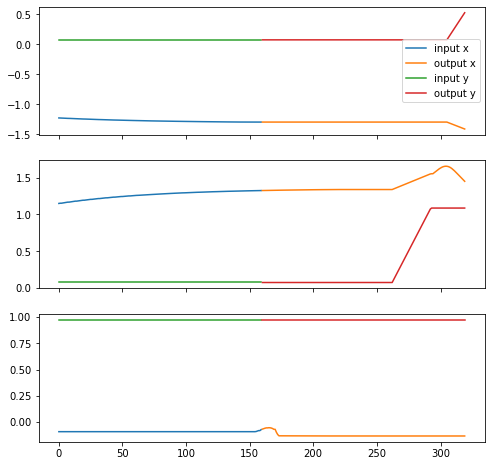

In [48]:
import matplotlib.pyplot as plt
iterator = iter(data_generator.train)
fig, ax = plt.subplots(3, 1, figsize=(8, 8), sharex=True)
for i in range(3):
    x, y = next(iterator)
    input_target_pos_x = x[0,:,:,0].numpy().flatten()
    input_target_pos_y = x[0,:,:,1].numpy().flatten()
    output_target_pos_x = y[0,:,:,0].numpy().flatten()
    output_target_pos_y = y[0,:,:,1].numpy().flatten()
    input_width = cfg.input_width * cfg.chunk_size
    output_width = cfg.output_width * cfg.chunk_size
    input_range = np.arange(0, input_width)
    output_range = np.arange(input_width, input_width + output_width)
    ax[i].plot(input_range, input_target_pos_x, label='input x')
    ax[i].plot(output_range, output_target_pos_x, label='output x')
    ax[i].plot(input_range, input_target_pos_y, label='input y')
    ax[i].plot(output_range, output_target_pos_y, label='output y')
    if i == 0:
        ax[i].legend()
plt.show()

### Code for the chunked model

In [49]:
class ChunkedModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.encoder = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(cfg.filters, 3, activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(cfg.hidden_width)
        ])
        self.encoder_layer = tf.keras.layers.TimeDistributed(self.encoder)
        self.lstm_cell = tf.keras.layers.LSTMCell(cfg.hidden_width)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.output_layer = tf.keras.layers.Dense(cfg.chunk_size * 10)
        self.output_reshape = tf.keras.layers.Reshape((cfg.output_width, cfg.chunk_size, 10))
        
    def warmup(self, x):
        x = self.encoder_layer(x)
        x, *state = self.lstm_rnn(x)
        return x, state
    
    def call(self, x, training=None):
        predictions = []
        x, state = self.warmup(x)
        
        first_prediction = self.output_layer(x)
        predictions.append(first_prediction)
        
        for _ in range(1, cfg.output_width):
            x, state = self.lstm_cell(x, states=state, training=training)
            next_prediction = self.output_layer(x)
            predictions.append(next_prediction)
            
        predictions = tf.transpose(tf.stack(predictions), [1, 0, 2])
        predictions = self.output_reshape(predictions)
        return predictions

### Trained the chunked model

In [50]:
weights_path = f'{base_path}/outputs/raw/weights.h5' #SET WEIGHTS PATH

In [51]:
model = ChunkedModel()
model(next(iter(data_generator.train))[0])
model.load_weights(weights_path)
print(f'Loaded weights from path {weights_path}')

Loaded weights from path C:\Users\dylan\Documents\Simulated/outputs/raw/weights.h5


### Evaluate chunked model on linear probe

In [52]:
class ProbeDataGenerator():
    def __init__(self):
        self.data_cols = ['target_posX', 'target_posY', 'target_posZ', 
                          'target_rotX', 'target_rotY', 'target_rotZ', 'target_rotW', 
                          'hand_posX', 'hand_posY', 'hand_posZ', 'hand_state']
        self.output_shapes = (
            (None, cfg.input_width, cfg.chunk_size, 10),
            (None, cfg.input_width)
        )
        self.output_types = (tf.float32, tf.int64)
        self.stores = {
            'train': pd.HDFStore(f'{base_path}/data/train.h5'),
            'dev': pd.HDFStore(f'{base_path}/data/dev.h5'),
            'test': pd.HDFStore(f'{base_path}/data/test.h5')
        }
        self.sessions = {
            'train': self.stores['train'].select_column('df', 'id').unique().tolist(),
            'dev': self.stores['dev'].select_column('df', 'id').unique().tolist(),
            'test': self.stores['test'].select_column('df', 'id').unique().tolist()
        }
        
    def generate_train(self):
        return self.generate('train')

    def generate_dev(self):
        return self.generate('dev')

    def generate_test(self):
        return self.generate('test')

    @property
    def train(self):
        return tf.data.Dataset.from_generator(self.generate_train, output_types=self.output_types, output_shapes=self.output_shapes)

    @property
    def dev(self):
        return tf.data.Dataset.from_generator(self.generate_dev, output_types=self.output_types, output_shapes=self.output_shapes)

    @property
    def test(self):
        return tf.data.Dataset.from_generator(self.generate_test, output_types=self.output_types, output_shapes=self.output_shapes)
    
    def generate(self, type):
        store = self.stores[type]
        sessions = self.sessions[type]
        random.shuffle(sessions)
        for session in sessions:
            df = store.select('df', 'id=%r' % session)
            assert df.index.values[0][0] == df.index.values[-1][0]
            data = df[self.data_cols].to_numpy(dtype=np.float32)
            ds = self.make_window_dataset(data)
            for x, y in ds:
                yield x, y
        
    def make_window_dataset(self, data):
        width = cfg.input_width * cfg.chunk_size
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=width,
            sequence_stride=width,
            sampling_rate=cfg.sampling_rate,
            shuffle=True,
            batch_size=cfg.batch_size,
            end_index=data.shape[0] - cfg.input_width
        )
        ds = ds.map(self.split_window)
        return ds
        
    def split_window(self, window):
        batch_size = tf.shape(window)[0]
        states = window[:, :, -1]
        window = window[:, :, :-1]
        states = tf.reshape(states, (batch_size, cfg.input_width, cfg.chunk_size))
        window = tf.reshape(window, (batch_size, cfg.input_width, cfg.chunk_size, 10))
        counts = tfp.stats.count_integers(tf.cast(states, tf.int32), axis=-1)
        states = tf.math.argmax(counts, axis=0, output_type=tf.int32)
        states.set_shape([None, cfg.input_width])
        window.set_shape([None, cfg.input_width, cfg.chunk_size, 10])
        return window, states
    
probe_generator = ProbeDataGenerator()

<b>Build the linear probe</b>

In [53]:
class LSTMProbe(tf.keras.Model):
    def __init__(self, model, use_lstm):
        super().__init__()
        self.model = model
        self.use_lstm = use_lstm
        self.rnn = tf.keras.layers.RNN(self.model.lstm_cell, return_sequences=True)
        self.output_layer = tf.keras.layers.Dense(10, activation='softmax')
        self.model.trainable = False
        self.rnn.trainable = False
        
    def call(self, x):
        x = self.model.encoder_layer(x)
        if self.use_lstm:
            x = self.rnn(x)
        return self.output_layer(x)

<b>Train the probe</b>

In [58]:
probe_weights_path = f'{base_path}/outputs/raw/probe_weights.h5' #SET PROBE WEIGHTS PATH

In [59]:
probe_model = LSTMProbe(model, False)
probe_model(next(iter(probe_generator.train))[0])
probe_model.load_weights(probe_weights_path)
print(f'Loaded weights from path: {probe_weights_path}')

Loaded weights from path: C:\Users\dylan\Documents\Simulated/outputs/raw/probe_weights.h5


<b>Evaluate the probe</b>

In [61]:
y_true = []
y_pred = []
for x, y in tqdm(probe_generator.dev):
    y_ = probe_model(x)
    y_ = tf.math.argmax(y_, axis=-1)
    y = tf.reshape(y, (-1,))
    y_ = tf.reshape(y_, (-1,))
    y_true.append(y)
    y_pred.append(y_)
y_true = tf.concat(y_true, axis=0)
y_pred = tf.concat(y_pred, axis=0)

100it [00:24,  4.13it/s]


In [60]:
acc = accuracy_score(y_true, y_pred)
scores = precision_recall_fscore_support(y_true, y_pred, average='macro')
print(f'Accuracy: {acc:.2f}\nPrecision: {scores[0]:.2f}\nRecall: {scores[1]:.2f}\nF-score: {scores[2]:.2f}')

Accuracy: 0.02
Precision: 0.04
Recall: 0.11
F-score: 0.01


# Contrastive Predictive Coding (CPC) Model

Chunked inputs <i>as well as output observations</i> are encoded with a convolutional encoder

An LSTM over the encoded inputs predicts the encoded outputs

Half of output sequences are incorrect. The model is trained to contrast real with fake inputs

<img src="../docs/CPC.png">

### Set hyperparameters

In [31]:
class Config():
    def __init__(self):
        self.batch_size = 256
        self.filters = 64
        self.hidden_width = 256
        self.input_width = 10
        self.output_width = 10
        self.sampling_rate = 1
        self.stride = 30
        self.chunk_size = 16
cfg = Config()

### Data generator

In [32]:
class CPCDataGenerator():
    def __init__(self):
        self.data_cols = ['target_posX', 'target_posY', 'target_posZ', 
                          'target_rotX', 'target_rotY', 'target_rotZ', 'target_rotW', 
                          'hand_posX', 'hand_posY', 'hand_posZ']
        self.output_shapes = ({
            'input_1': (None, cfg.input_width, cfg.chunk_size, 10),
            'input_2': (None, cfg.output_width, cfg.chunk_size, 10)
        }, (None,))
        self.output_types = ({'input_1': tf.float32, 'input_2': tf.float32}, tf.int64)
        self.stores = {f: pd.HDFStore(f'{base_path}/data/{f}.h5') for f in ['train', 'dev', 'test']}
        self.sessions = {
            'train': self.stores['train'].select_column('df', 'id').unique().tolist(),
            'dev': self.stores['dev'].select_column('df', 'id').unique().tolist(),
            'test': self.stores['test'].select_column('df', 'id').unique().tolist(),
        }

    def generate_train(self):
        return self.generate('train')

    def generate_dev(self):
        return self.generate('dev')

    def generate_test(self):
        return self.generate('test')

    @property
    def train(self):
        return tf.data.Dataset.from_generator(self.generate_train, output_types=self.output_types, output_shapes=self.output_shapes)

    @property
    def dev(self):
        return tf.data.Dataset.from_generator(self.generate_dev, output_types=self.output_types, output_shapes=self.output_shapes)

    @property
    def test(self):
        return tf.data.Dataset.from_generator(self.generate_test, output_types=self.output_types, output_shapes=self.output_shapes)

    def generate(self, type):
        store = self.stores[type]
        sessions = self.sessions[type]
        random.shuffle(sessions)
        for i in range(len(sessions)):
            df = store.select('df', 'id=%r' % sessions[i])
            assert df.index.values[0][0] == df.index.values[-1][0]
            steps = df.index.get_level_values(1).to_numpy()[:, np.newaxis].astype(int)
            data = df[self.data_cols].to_numpy()
            data = np.concatenate([steps, data], axis=-1)
            ds = self.make_window_dataset(data)
            for x_input, x_output, steps in ds:
                x_input, x_output, y = self.prepare_batch(x_input, x_output)
                yield {'input_1': x_input, 'input_2': x_output}, y

    def generate_negative_samples(self, x_input, x_output):
        batch_size, output_width, _, _ = tf.shape(x_output)
        session = random.choice(self.sessions['train'])
        df = self.stores['train'].select('df', 'id=%r' % session)
        data = df[self.data_cols].to_numpy()
        data = data[:(data.shape[0] // cfg.chunk_size * cfg.chunk_size), :]
        data = data.reshape((-1, cfg.chunk_size, 10))
        indices = np.random.choice(data.shape[0], size=(batch_size, output_width))
        x_output = data[indices]
        return x_input, x_output

    def prepare_batch(self, x_input, x_output):
        batch_size = tf.shape(x_input)[0]
        y_pos = tf.ones(shape=(batch_size // 2,))
        y_neg = tf.zeros(shape=(batch_size // 2,))
        y = tf.concat([y_pos, y_neg], axis=0)
        x_input_neg = x_input[:batch_size // 2, :, :]
        x_output_pos = x_output[:batch_size // 2, :, :]
        x_output_neg = x_output[batch_size // 2:, :, :]
        x_input_neg, x_output_neg = self.generate_negative_samples(x_input_neg, x_output_neg)
        x_output = tf.concat([x_output_pos, x_output_neg], axis=0)
        indices = tf.random.shuffle(tf.range(batch_size))
        x_input = tf.gather(x_input, indices)
        x_output = tf.gather(x_output, indices)
        y = tf.gather(y, indices)
        return x_input, x_output, y

    def split_window(self, window):
        batch_size = tf.shape(window)[0]
        steps = window[:, cfg.input_width:, 0]
        window = window[:, :, 1:]
        input_width = cfg.input_width * cfg.chunk_size
        x_input = tf.reshape(window[:, :input_width, :], (batch_size, cfg.input_width, cfg.chunk_size, 10))
        x_output = tf.reshape(window[:, input_width:, :], (batch_size, cfg.output_width, cfg.chunk_size, 10))
        x_input.set_shape([None, cfg.input_width, cfg.chunk_size, 10])
        x_output.set_shape([None, cfg.output_width, cfg.chunk_size, 10])
        return x_input, x_output, steps

    def make_window_dataset(self, window):
        window = np.array(window, dtype=np.float32)
        total_width = (cfg.input_width + cfg.output_width) * cfg.chunk_size
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=window,
            targets=None,
            sequence_length=total_width,
            sequence_stride=cfg.stride,
            sampling_rate=cfg.sampling_rate,
            shuffle=True,
            batch_size=cfg.batch_size,
            end_index=window.shape[0] - total_width
        )
        ds = ds.map(self.split_window)
        return ds
    
data_generator = CPCDataGenerator()

<b>Visualize the data</b>

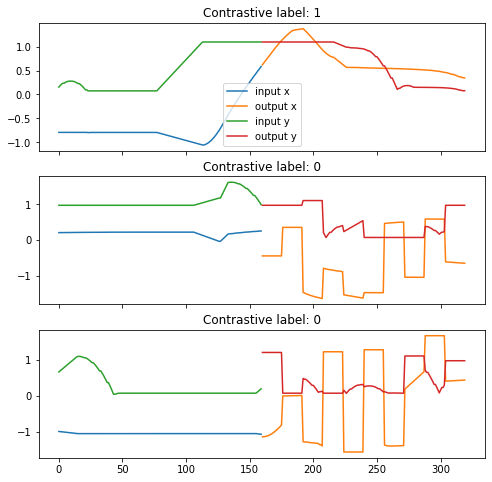

In [35]:
import matplotlib.pyplot as plt
iterator = iter(data_generator.train)
fig, ax = plt.subplots(3, 1, figsize=(8, 8), sharex=True)
for i in range(3):
    inputs, label = next(iterator)
    x, y = inputs['input_1'], inputs['input_2']
    input_target_pos_x = x[0,:,:,0].numpy().flatten()
    input_target_pos_y = x[0,:,:,1].numpy().flatten()
    output_target_pos_x = y[0,:,:,0].numpy().flatten()
    output_target_pos_y = y[0,:,:,1].numpy().flatten()
    input_width = cfg.input_width * cfg.chunk_size
    output_width = cfg.output_width * cfg.chunk_size
    input_range = np.arange(0, input_width)
    output_range = np.arange(input_width, input_width + output_width)
    ax[i].plot(input_range, input_target_pos_x, label='input x')
    ax[i].plot(output_range, output_target_pos_x, label='output x')
    ax[i].plot(input_range, input_target_pos_y, label='input y')
    ax[i].plot(output_range, output_target_pos_y, label='output y')
    if i == 0:
        ax[i].legend()
    ax[i].title.set_text('Contrastive label: ' + str(label[0].numpy()))
plt.show()

<b>Code for the CPC model</b>

In [36]:
class CPCModel(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.encoder = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(cfg.filters, 3, activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(cfg.hidden_width, activation='relu')
        ])
        self.encoder_layer = tf.keras.layers.TimeDistributed(self.encoder)
        self.lstm_cell = tf.keras.layers.LSTMCell(cfg.hidden_width)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.output_layer = tf.keras.layers.Dense(cfg.hidden_width, activation='relu')

    def warmup(self, x):
        x, *state = self.lstm_rnn(x)
        return x, state

    def call(self, inputs, training=None):
        x_input = inputs['input_1']
        x_output = inputs['input_2']
        x_input_encoded = self.encoder_layer(x_input)
        x_output_encoded = self.encoder_layer(x_output)

        predictions = []
        x, state = self.warmup(x_input_encoded)

        output = self.output_layer(x)
        predictions.append(output)

        for _ in range(1, cfg.output_width):
            x, state = self.lstm_cell(x, states=state, training=training)
            output = self.output_layer(x)
            predictions.append(output)

        predictions = tf.stack(predictions, axis=1)
        y = tf.linalg.norm(predictions - x_output_encoded)
        return y

<b>Train the CPC model</b>

In [37]:
weights_path = f'{base_path}/outputs/cpc/weights.h5' #SET WEIGHTS PATH

In [38]:
model = CPCModel()
model(next(iter(data_generator.train))[0])
model.load_weights(weights_path)
print(f'Loaded weights from path {weights_path}')

Loaded weights from path C:\Users\dylan\Documents\Simulated/outputs/cpc/weights.h5


### Evaluate on linear probe

<font color="red"><b>Using the same generator as in the chunked model, load if necessary</b></font>

<b>Build the probe</b>

In [39]:
class CPCProbe(tf.keras.Model):
    def __init__(self, model, use_lstm):
        super().__init__()
        self.model = model
        self.use_lstm = use_lstm
        self.rnn = tf.keras.layers.RNN(self.model.lstm_cell, return_sequences=True)
        self.dense = tf.keras.layers.Dense(10, activation='softmax')
        self.model.trainable = False
        self.rnn.trainable = False

    def call(self, x):
        x = self.model.encoder_layer(x)
        if self.use_lstm:
            x = self.rnn(x)
        return self.dense(x)

<b>Train the probe</b>

In [40]:
probe_weights_path = f'{base_path}/outputs/cpc/probe_weights.h5' #SET PROBE WEIGHTS PATH

In [41]:
probe_model = CPCProbe(model, False)
probe_model(next(iter(probe_generator.train))[0])
probe_model.load_weights(probe_weights_path)
print(f'Loaded weights from path: {probe_weights_path}')

Loaded weights from path: C:\Users\dylan\Documents\Simulated/outputs/cpc/probe_weights.h5


<b>Evaluate the probe</b>

In [42]:
y_true = []
y_pred = []
for x, y in tqdm(probe_generator.dev):
    y_ = probe_model(x)
    y_ = tf.math.argmax(y_, axis=-1)
    y = tf.reshape(y, (-1,))
    y_ = tf.reshape(y_, (-1,))
    y_true.append(y)
    y_pred.append(y_)
y_true = tf.concat(y_true, axis=0)
y_pred = tf.concat(y_pred, axis=0)

100it [00:26,  3.78it/s]


In [43]:
acc = accuracy_score(y_true, y_pred)
scores = precision_recall_fscore_support(y_true, y_pred, average='macro')
print(f'Accuracy: {acc:.2f}\nPrecision: {scores[0]:.2f}\nRecall: {scores[1]:.2f}\nF-score: {scores[2]:.2f}')

Accuracy: 0.70
Precision: 0.08
Recall: 0.11
F-score: 0.09


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
